In [76]:
import os
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from pycbc import psd as psd_func
from pycbc.filter import sigma, match
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import (generate_eccentric_waveform, calculate_eccentric_harmonics,
                                 calc_f_gen, shifted_f, shifted_e, calculate_mode_snr, generate_eccentric_waveform_MA)
from simple_pe.param_est import find_metric_and_eigendirections, component_mass_prior_weight, result, pe
from calcwf import match_hn
from interpolating_match import comb_harm_consistent

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Is MA measurement consistent across harmonics with different parameters?

In [17]:
M = 60
q = 2
e = 0.2
f = 10

h, _ = generate_eccentric_waveform(M, q, e, 0, 0, f, 4096, tlen=32, to_fs=False)
harms = calculate_eccentric_harmonics(M, q, e, 0, 0, f, 4096, tlen=32, n_ecc_harms=2)
wf_hjs = [harms[key].to_timeseries() for key in [0,1]]
matches = match_hn(wf_hjs, h, 10, f_match=20)
true_MA = (np.angle(matches[1])-np.angle(matches[0]))%(2*np.pi)
print(f'True MA: {true_MA:.2f}')

MAs = []
for i in range(10):
    harm_M = np.random.uniform(59,61)
    harm_q = np.random.uniform(1.9,2.1)
    harm_e = np.random.uniform(0.19,0.21)
    harm_chi1 = np.random.uniform(0.05,-0.05)
    harm_chi2 = np.random.uniform(0.05,-0.05)
    harms = calculate_eccentric_harmonics(harm_M, harm_q, harm_e, harm_chi1, harm_chi2, f, 4096, tlen=32, n_ecc_harms=2)
    wf_hjs = [harms[key].to_timeseries() for key in [0,1]]
    matches = match_hn(wf_hjs, h, 10, f_match=20)
    print(f'0: M = {np.abs(matches[0]):.2f} with angle of {np.angle(matches[0])%(2*np.pi):.2f}')
    print(f'1: M = {np.abs(matches[1]):.2f} with angle of {np.angle(matches[1])%(2*np.pi):.2f}')
    MAs.append((np.angle(matches[1])-np.angle(matches[0]))%(2*np.pi))
    print(f'MA measurement: {MAs[-1]:.2f}')

True MA: 0.70
0: M = 0.97 with angle of 3.35
1: M = 0.20 with angle of 3.51
MA measurement: 0.16
0: M = 0.96 with angle of 5.73
1: M = 0.20 with angle of 3.81
MA measurement: 4.37
0: M = 0.93 with angle of 6.02
1: M = 0.13 with angle of 0.30
MA measurement: 0.56
0: M = 0.94 with angle of 1.76
1: M = 0.16 with angle of 1.71
MA measurement: 6.23
0: M = 0.96 with angle of 1.79
1: M = 0.20 with angle of 2.43
MA measurement: 0.64
0: M = 0.97 with angle of 3.03
1: M = 0.21 with angle of 3.44
MA measurement: 0.40
0: M = 0.97 with angle of 1.18
1: M = 0.22 with angle of 5.18
MA measurement: 4.01
0: M = 0.95 with angle of 4.11
1: M = 0.21 with angle of 2.96
MA measurement: 5.14
0: M = 0.96 with angle of 5.83
1: M = 0.18 with angle of 3.48
MA measurement: 3.94
0: M = 0.96 with angle of 2.38
1: M = 0.15 with angle of 0.68
MA measurement: 4.58


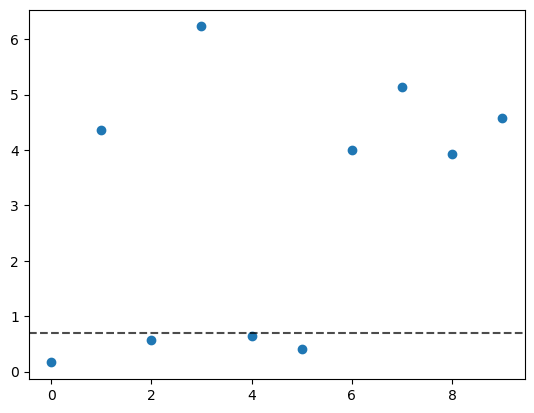

In [18]:
plt.scatter(np.arange(len(MAs)), MAs)
plt.axhline(true_MA, c='k', ls='dashed', alpha=0.7)

The MA measurement is therefore not consistent across harmonics built at different points in parameter space - suspect it is likely linked/normalised relative to MA of e.g. s_0 when building harmonics.

# Finding peak ecc/MA

In [80]:
with open(os.path.join('grid_data_4d', 'dataslot_8', 'all_matches'), 'rb') as fp:
    all_matches = pickle.load(fp)
with open(os.path.join('grid_data_4d', 'dataslot_8', 'param_samples'), 'rb') as fp:
    param_samples = pickle.load(fp)

The peak point on the degeneracy line we should find in using a 'linear' parameter, i.e. e^2, chirp mass etc, and find peak density using a gaussian kde.

To find peak MA we will use the same approach.

To draw the samples on MA that we need (and will combine with samples drawn from new metric), we will use inverse transform sampling from the kde we built to find the peak.

In [81]:
def get_peak_e_MA(all_matches, param_samples, n_MA=0):

    # Build kde and find peak for e
    e2_kernel = gaussian_kde(param_samples['samples']['ecc10']**2)
    e2_arr = np.linspace(0, np.max(param_samples['samples']['ecc10'])**2, 10**3)
    e2_kde_dens = e2_kernel(e2_arr)
    e2_peak = e2_arr[np.argmax(e2_kde_dens)]

    # Build kde and find peak for MA
    MA_kde_builders = np.concatenate([param_samples['samples']['MA'], param_samples['samples']['MA']+2*np.pi, param_samples['samples']['MA']-2*np.pi])
    MA_kernel = gaussian_kde(MA_kde_builders, bw_method=0.01)
    MA_arr = np.linspace(0,2*np.pi,10**3,endpoint=False)
    MA_kde_dens = MA_kernel(MA_arr)
    MA_peak = MA_arr[np.argmax(MA_kde_dens)]

    # Build peak dictionary
    base_dict = all_matches['metadata']['base_params']
    fid_dict = all_matches['metadata']['fid_params']
    degen_dist = (e2_peak-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    peak_dict = {'MA': MA_peak}
    for key in list(all_matches['metadata']['fid_params'].keys()):
        peak_dict[key] = degen_dist*(fid_dict[key]-base_dict[key])+base_dict[key]

    # Draw more samples on MA using inverse transform sampling from kde
    if n_MA > 0:
        MA_draw = np.concatenate([[0], MA_arr[1:], [2*np.pi]])
        MA_cumsum = np.cumsum(MA_kde_dens)
        MA_cdf_2pi = MA_cumsum[-1]+MA_kde_dens[0]
        MA_cdf = np.concatenate([[0], MA_cumsum[1:]/MA_cdf_2pi, [1]])
        MA_uni_samples = np.random.rand(n_MA)
        MA_draw_interp = interp1d(MA_cdf, MA_draw)
        MA_samples = MA_draw_interp(MA_uni_samples)
        return peak_dict, MA_samples
    else:
        return peak_dict

In [82]:
peak_dict, MA_samples = get_peak_e_MA(all_matches, param_samples, n_MA=10**6)
print(peak_dict)

{'MA': 0.6848671984825749, 'ecc10sqrd': 0.0317897548807485, 'chirp_mass': 24.28587947335138, 'symmetric_mass_ratio': 0.20306357014978405, 'chi_eff': 0.11955229707475908}


In [83]:
_ = plt.hist(param_samples['samples']['MA'], bins=50, range=(0,2*np.pi), density=True, histtype='step')
plt.axvline(peak_dict['MA'], c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)

(0.0, 6.283185307179586)

In [84]:
_ = plt.hist(param_samples['samples']['MA'], bins=50, range=(0,2*np.pi), density=True, histtype='step', label='original')
_ = plt.hist(MA_samples, bins=50, range=(0,2*np.pi), density=True, histtype='step', label='new')
plt.axvline(peak_dict['MA'], c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)
plt.legend()

# Calculating metric at peak and drawing samples

Here we will calculate the metric at the new peak values (mean anomaly is not important here as we will use the h0 harmonic for metric calculation).

We can then draw samples from the metric, and add the MA distribution calculated in the previous step.

First off however we need to 'recalibrate' the mean anomaly to the new set of harmonics. We can also generate the harmonics at the peak parameters here and use it for future steps.

In [85]:
def recal_MA(all_matches, peak_dict, n_ecc_harms, n_ecc_gen, f_low, psd, sample_rate, two_ecc_harms=True, MA_samples=None):

    # Calculate harmonic ordering
    harm_ids = [0,1]
    for i in range(2,n_ecc_harms):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)

    # Generate harmonics at peak
    peak_dict['mass_ratio'] = q_from_eta(peak_dict['symmetric_mass_ratio'])
    peak_dict['inverted_mass_ratio'] = 1/peak_dict['mass_ratio']
    peak_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(peak_dict['chirp_mass'], peak_dict['mass_ratio']), axis=0)
    tlen = int(1/psd.delta_f)
    wf_dict = calculate_eccentric_harmonics(peak_dict['total_mass'], peak_dict['inverted_mass_ratio'], peak_dict['ecc10sqrd']**0.5, peak_dict['chi_eff'],
                                            peak_dict['chi_eff'], f_low, sample_rate, tlen=tlen, f_ref_e=10, n_ecc_harms=n_ecc_harms, n_ecc_gen=n_ecc_gen)
    wf_hjs = [wf_dict[ind].to_timeseries() for ind in harm_ids]

    # Test three MA values from gridded matches
    dist_to_peak = np.abs(all_matches['metadata']['degen_params']['ecc10sqrd']-peak_dict['ecc10sqrd'])
    idx = np.argpartition(dist_to_peak, 3)[:3]
    f_gen = calc_f_gen(f_low, n_ecc_harms)
    MA_diff_cplx = 0j
    for pos in idx:
        params = {key: all_matches['metadata']['degen_params'][key][pos] for key in all_matches['metadata']['degen_params'].keys()}
        h = generate_eccentric_waveform(params['total_mass'], params['inverted_mass_ratio'], params['ecc10'], params['chi_eff'],
                                        params['chi_eff'], f_gen, sample_rate, f_ref_e=10, tlen=tlen, to_fs=False)[0]
        match_cplx = match_hn(wf_hjs, h, f_gen, psd=psd, f_match=f_low)
        if two_ecc_harms:
            MA_old = all_matches['h1_h-1_h0_pc_phase'][pos][0]
            _, MA_new = comb_harm_consistent(np.abs(match_cplx[:3]), np.angle(match_cplx[:3]), harms=[0,1,-1])
        else:
            MA_old = (all_matches['h1_phase'][pos][0]-all_matches['h0_phase'][pos][0])%(2*np.pi)
            MA_new = (np.angle(match_cplx[1])-np.angle(match_cplx[0]))%(2*np.pi)
        MA_diff_cplx += np.exp(1j*(MA_new - MA_old))
    MA_diff = np.angle(MA_diff_cplx)

    # Return calibrated peak MA and MA samples
    peak_dict['recal_MA'] = (peak_dict['MA']+MA_diff)%(2*np.pi)
    if MA_samples is None:
        return peak_dict, wf_hjs
    else:
        recal_MA_samples = (MA_samples+MA_diff)%(2*np.pi)
        return peak_dict, recal_MA_samples, wf_hjs

In [86]:
# Create psd
f_low = 20
sample_rate = 4096
tlen = 32
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

In [87]:
# Recalibrate to 'new' MA normalisation
peak_dict, recal_MA_samples, wf_hjs = recal_MA(all_matches, peak_dict, 4, 6, f_low, psd['H1'], sample_rate, MA_samples=MA_samples, two_ecc_harms=True)

# Generate true waveform with same parameters as used to generate this analysis to compare to 'true' MA
target_snr = 20
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
data, _ = generate_eccentric_waveform(true_dict['total_mass'], true_dict['inverted_mass_ratio'], true_dict['ecc10sqrd']**0.5,
                                      true_dict['chi_eff'], true_dict['chi_eff'], 10, sample_rate, f_ref_e=10, tlen=tlen, to_fs=False)
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = data*target_snr/raw_snr
f_gen = calc_f_gen(f_low, 4)
match_cplx = match_hn(wf_hjs, data, f_gen, psd=psd['H1'], f_match=f_low)
true_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0]))%(2*np.pi)

# Plot true MA on recalibrated MA samples to ensure they match
_ = plt.hist(recal_MA_samples, bins=50, range=(0,2*np.pi), histtype='step')
plt.axvline(true_MA, c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)

(0.0, 6.283185307179586)

The recalibration seems to be working well.

In [88]:
def get_peak_snr(data, wf_hjs, f_low, psd, harm_ids):
    
    # Endure harmonics are normalised
    harm_dict = {}
    for wf, hid in zip(wf_hjs, harm_ids):
        harm_dict[hid] = wf / sigma(wf, psd, low_frequency_cutoff=f_low,
                                    high_frequency_cutoff=psd.sample_frequencies[-1])

    # Get SNR in each harmonic
    mode_SNRs, _ = calculate_mode_snr(data, psd, harm_dict, data.sample_times[0],
                                      data.sample_times[-1], f_low, harm_dict.keys(), dominant_mode=0)
    
    return mode_SNRs

In [89]:
peak_SNRs = get_peak_snr(data, wf_hjs, f_low, psd['H1'], [0,1,-1,2])

Now with the SNR calculated using these functions we can calculate the new metric.

We can use the result object from simple-pe to do this.

In [12]:
def create_pe_result(peak_dict, SNRs, f_low, psd_dict):

    # Define necessary parameters
    snr_threshold = 4
    metric_dirs = ['chirp_mass', 'chi_eff', 'symmetric_mass_ratio', 'ecc10sqrd']
    template_parameters = {key: peak_dict[key] for key in metric_dirs}
    data_from_matched_filter = {
        "template_parameters": template_parameters,
        "snrs": {key: np.abs(SNRs[key]) for key in SNRs.keys()}
    }

    # Create object
    pe_result = result.Result(
        f_low=f_low, psd=psd_dict,
        approximant='TEOBResumS-Dali-Harms',
        snr_threshold=snr_threshold,
        data_from_matched_filter=data_from_matched_filter
    )

    # Generate_metric
    pe_result.generate_metric(metric_dirs, dominant_snr=np.abs(SNRs[0]), max_iter=2, multiprocessing=True)

    return pe_result

In [13]:
# Only calculates pe_result if requested, otherwise loads from file
recalc_pe_result = False
if recalc_pe_result:
    start = time.time()
    pe_result = create_pe_result(peak_dict, peak_SNRs, f_low, psd)
    end = time.time()
    print(end-start)
    with open(os.path.join('data', '4d_samples_pe_result'), 'wb') as fp:
        pickle.dump(pe_result, fp)
else:
    with open(os.path.join('data', '4d_samples_pe_result'), 'rb') as fp:
        pe_result = pickle.load(fp)

We will now generate samples and reweight to uniform prior in mass ratio (0<=q<=1).

We should also reweight eccentricity to either a uniform or log-uniform prior.

In [14]:
def loguniform_e_prior_weight(samples, dx_directions):
    from pesummary.core.reweight import rejection_sampling
    low_e_cutoff = 0.02
    if 'ecc10sqrd' in dx_directions:
        e_weights = 1/np.maximum(low_e_cutoff**2, samples['ecc10sqrd'])
    elif 'ecc10' in dx_directions:
        e_weights = 1/np.maximum(low_e_cutoff**2, samples['ecc10']**2)
    else:
        e_weights = np.ones_like(samples['chirp_mass'])

    return rejection_sampling(samples, e_weights)

def uniform_e_prior_weight(samples, dx_directions):
    from pesummary.core.reweight import rejection_sampling
    low_e_cutoff = 0.005
    if 'ecc10sqrd' in dx_directions:
        e_weights = 1/np.maximum(low_e_cutoff, np.sqrt(samples['ecc10sqrd']))
    elif 'ecc10' in dx_directions:
        e_weights = 1/np.maximum(low_e_cutoff, samples['ecc10'])
    else:
        e_weights = np.ones_like(samples['chirp_mass'])

    return rejection_sampling(samples, e_weights)

In [15]:
# Generate samples from metric
npts = int(1e7)
_ = pe_result.generate_samples_from_metric(npts=npts)
pe_result.reweight_samples(uniform_e_prior_weight,
                           dx_directions=pe_result.metric.dx_directions)
pe_result.reweight_samples(pe.component_mass_prior_weight,
                           dx_directions=pe_result.metric.dx_directions)

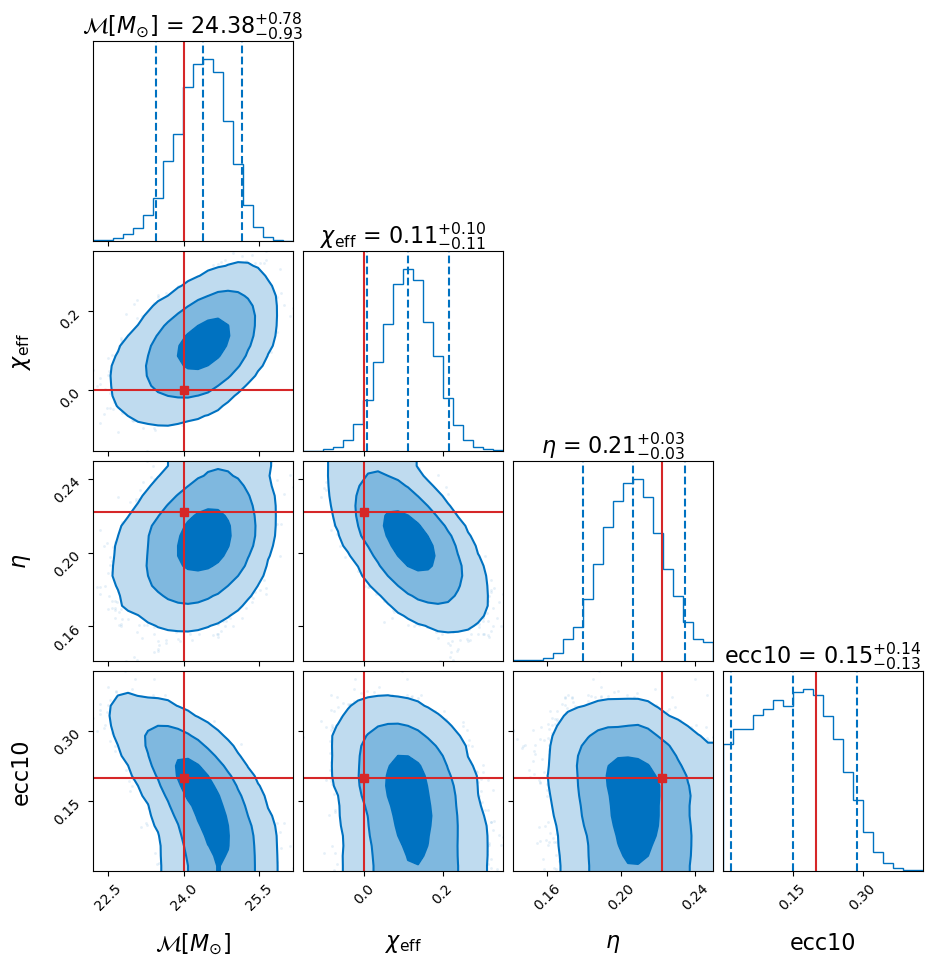

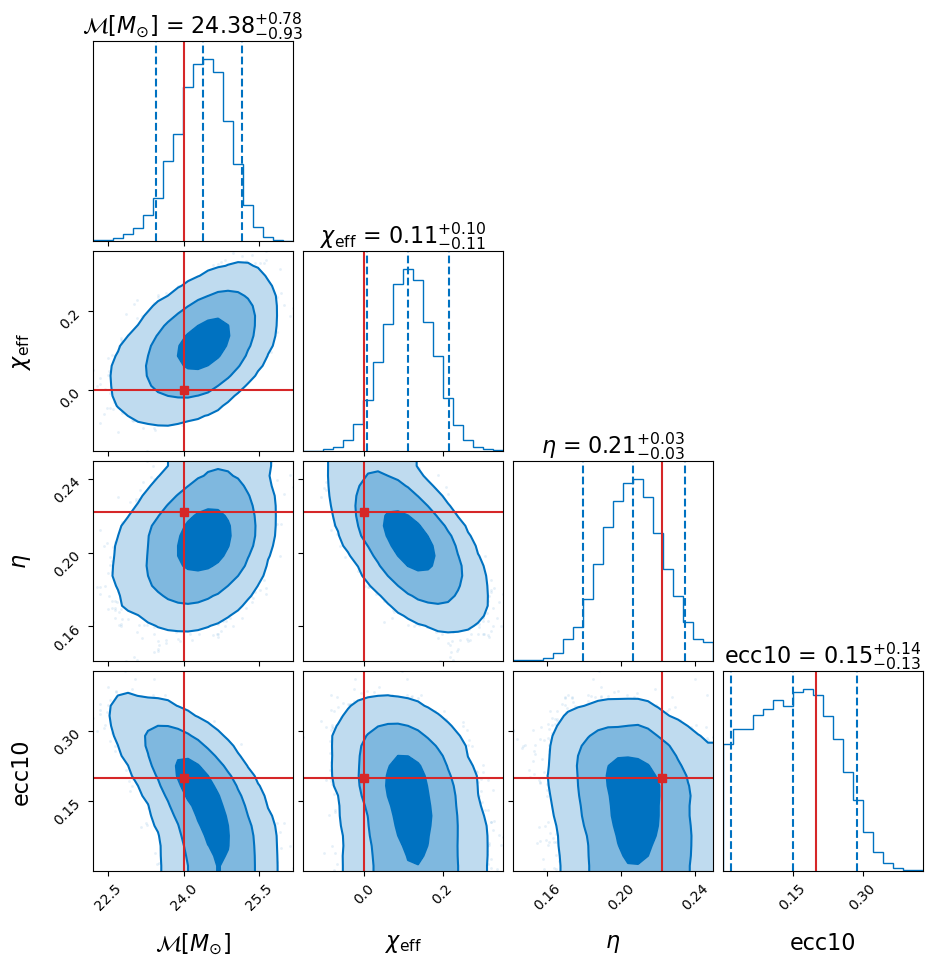

In [16]:
# Plot samples
corner_params = ['chirp_mass', 'chi_eff', 'symmetric_mass_ratio', 'ecc10']
injected_vals = [24, 0, 2/9, 0.2]
samples = pe.SimplePESamples(pe_result.samples_dict)
samples['ecc10'] = np.sqrt(samples['ecc10sqrd'])
samples.plot(parameters=corner_params, truths=injected_vals, type="corner",
             quantiles=[0.05, 0.5, 0.95], show_titles=True, truth_color='C3')

Note this is before using information from higher harmonics.

# 5x5x5x5 grid

In [17]:
interp_points = 5
eccentricity_directions = ['chirp_mass', 'ecc10sqrd']
wf_dict = {k: wf_hjs[i] for i, k in enumerate([0, 1, -1])}
ecc_SNR_grid = pe_result.calculate_ecc_SNR_grid(
                    interp_directions=eccentricity_directions,
                    psd=psd['H1'],
                    f_low=f_low,
                    interp_points=interp_points,
                    MA=peak_dict['recal_MA'],
                    ecc_harms=wf_dict
                )

calculating eccentric SNR on grid: 100%|██████████| 25/25 [02:34<00:00,  6.18s/it]


(-0.5063036065256571, 0.5063036065256571)

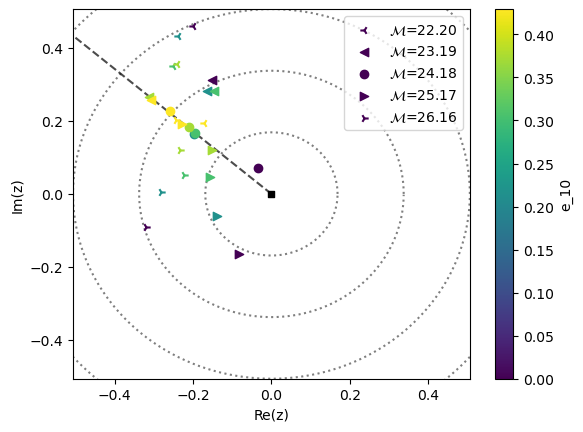

In [73]:
# Plot grid points
chirp_shapes = ['3', '<', 'o', '>', '4']
ecc_cmap = 'viridis'
eccs = np.sqrt(ecc_SNR_grid[0][1][1])
for i in range(len(ecc_SNR_grid[0][0])):
    for j in range(len(ecc_SNR_grid[0][0][i])):
        if j == 0:
            label='$\mathcal{M}$'+f'={ecc_SNR_grid[0][1][0][i]:.2f}'
        else:
            label=None
        plt.scatter(np.real(ecc_SNR_grid[0][0][i][j]), np.imag(ecc_SNR_grid[0][0][i][j]),
                    marker=chirp_shapes[i], c=eccs[j], cmap=ecc_cmap, vmin=0, vmax=eccs[-1], label=label)
plt.colorbar(label='e_10')
max_x = np.max(np.abs(np.real(ecc_SNR_grid[0][0])))
max_y = np.max(np.abs(np.imag(ecc_SNR_grid[0][0])))
lims = np.max([max_x, max_y])*1.1

# Plot peak SNR gaussian samples
plt.plot

# Plot centre rings and recal_MA line
xs = np.linspace(0, np.sqrt(2), 2) * np.cos(peak_dict['recal_MA'])
ys = np.linspace(0, np.sqrt(2), 2) * np.sin(peak_dict['recal_MA'])
plt.plot(xs, ys, c='k', alpha=0.7, ls='dashed', zorder=0)
plt.scatter(0, 0, marker='s', s=15, c='k')
for i in range(4):
    r = (i+1)*(lims/3)
    angs = np.linspace(0, 2*np.pi, 1001, endpoint=False)
    plt.plot(r*np.cos(angs), r*np.sin(angs), c='k', alpha=0.5, ls='dotted', zorder=0)

# Formatting
plt.legend(loc='upper right')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.xlim(-lims,lims)
plt.ylim(-lims,lims)